In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from ucimlrepo import fetch_ucirepo 

In [2]:
# fetch dataset 
Drugs = fetch_ucirepo(id=462) 

In [3]:
# data (as pandas dataframes) 
drug_features = Drugs.data.features
  
# variable info. 
print(Drugs.metadata["additional_info"]["variable_info"]) 

1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful


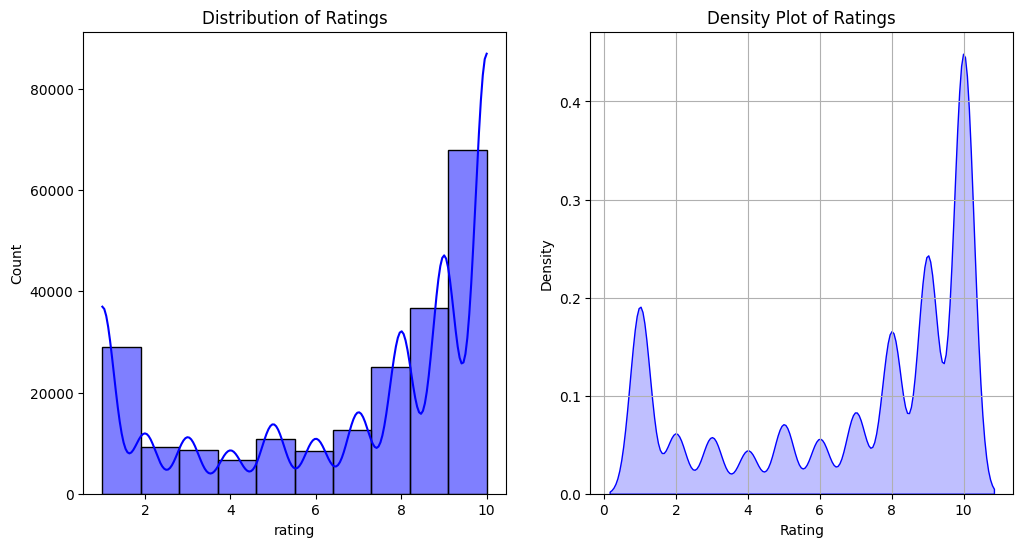

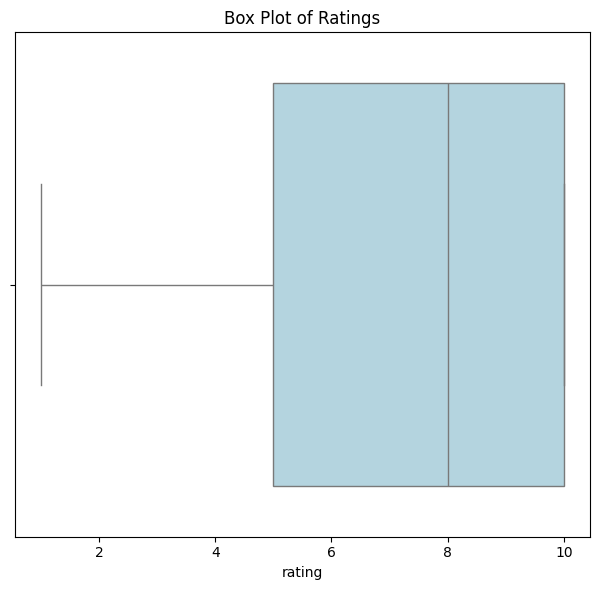

In [4]:
# Histogram for numerical variables (rating and usefulCount, assuming they exist)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(drug_features["rating"], bins=10, kde=True, color="blue")
plt.title("Distribution of Ratings")

plt.subplot(1, 2, 2)
sns.kdeplot(drug_features['rating'], fill=True, color='blue')
plt.title('Density Plot of Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.grid(True)

# Box plots to show spread and outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=drug_features["rating"], color="lightblue")
plt.title("Box Plot of Ratings")

plt.tight_layout()
plt.show()

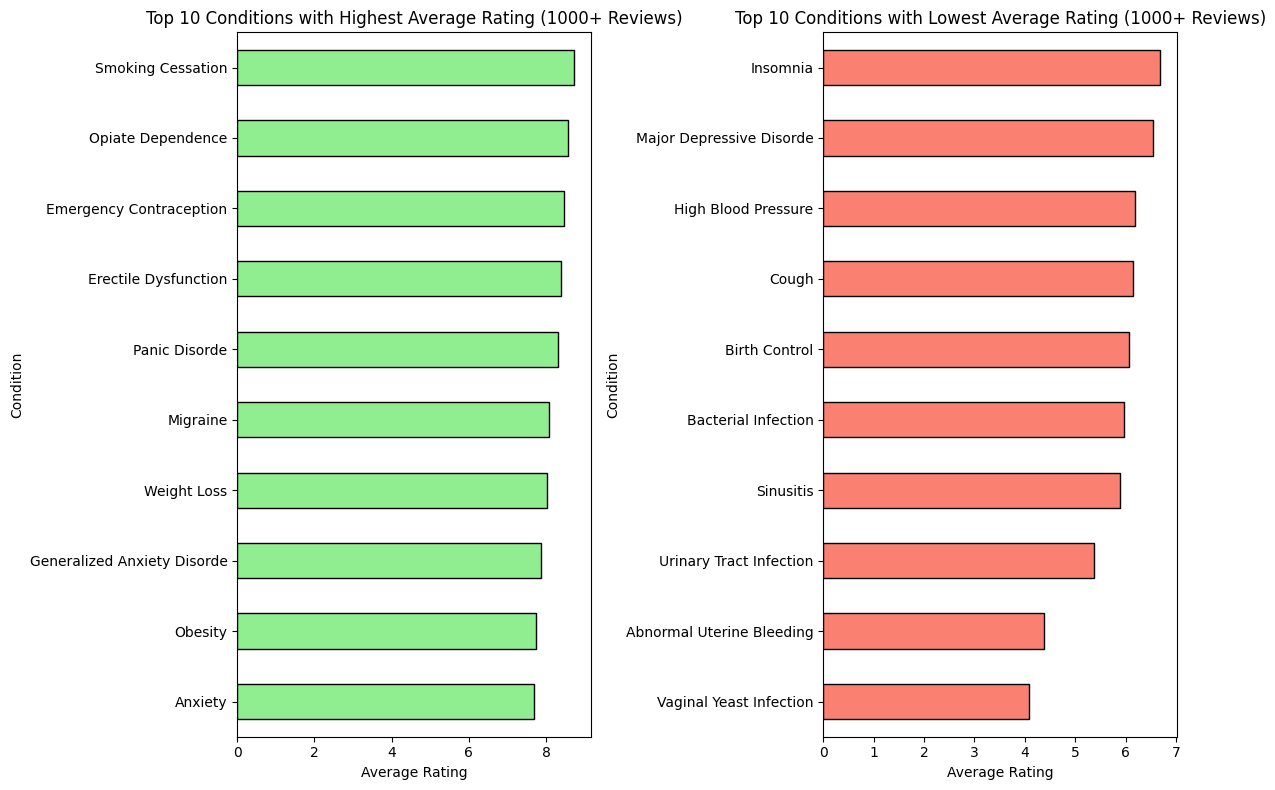

In [5]:
# Calculate the average rating for each condition
avg_rating_per_condition = drug_features.groupby("condition")["rating"].mean()
condition_review_counts = drug_features.groupby("condition").size()  # Count the number of reviews for each condition

conditions_at_least_100_reviews = condition_review_counts[condition_review_counts >= 1000].index
filtered_avg_ratings = avg_rating_per_condition.loc[conditions_at_least_100_reviews]

# Sort the conditions by average rating
sorted_ratings = filtered_avg_ratings.sort_values()

# Visualize the top 10 highest and lowest rated conditions with at least 100 reviews
plt.figure(figsize=(12, 8))

# Plot the top 10 highest rated conditions
plt.subplot(1, 2, 1)
sorted_ratings.tail(10).plot(kind="barh", color="lightgreen", edgecolor="black")
plt.title("Top 10 Conditions with Highest Average Rating (1000+ Reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Condition")

# Plot the top 10 lowest rated conditions
plt.subplot(1, 2, 2)
sorted_ratings.head(10).plot(kind="barh", color="salmon", edgecolor="black")
plt.title("Top 10 Conditions with Lowest Average Rating (1000+ Reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Condition")

# Display the plots
plt.tight_layout()
plt.show()

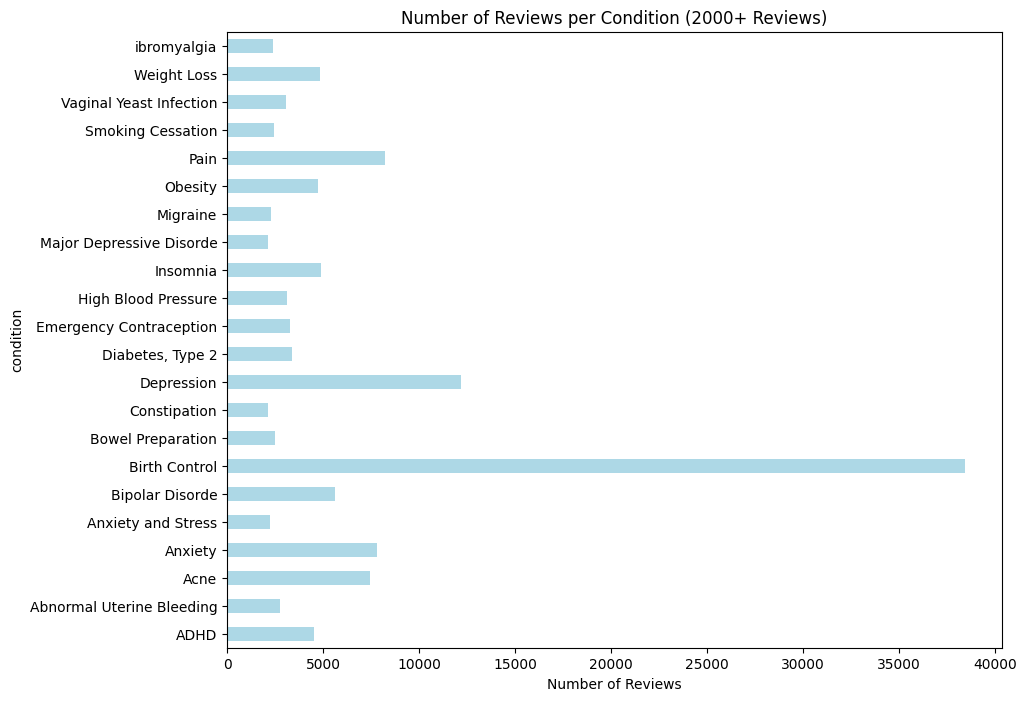

In [6]:
conditions_large_reviews = condition_review_counts[condition_review_counts >= 2000]

plt.figure(figsize=(12, 5))
conditions_large_reviews.plot(kind="barh", figsize=(10, 8), color="lightblue")
plt.title("Number of Reviews per Condition (2000+ Reviews)")
plt.xlabel("Number of Reviews")
plt.show()

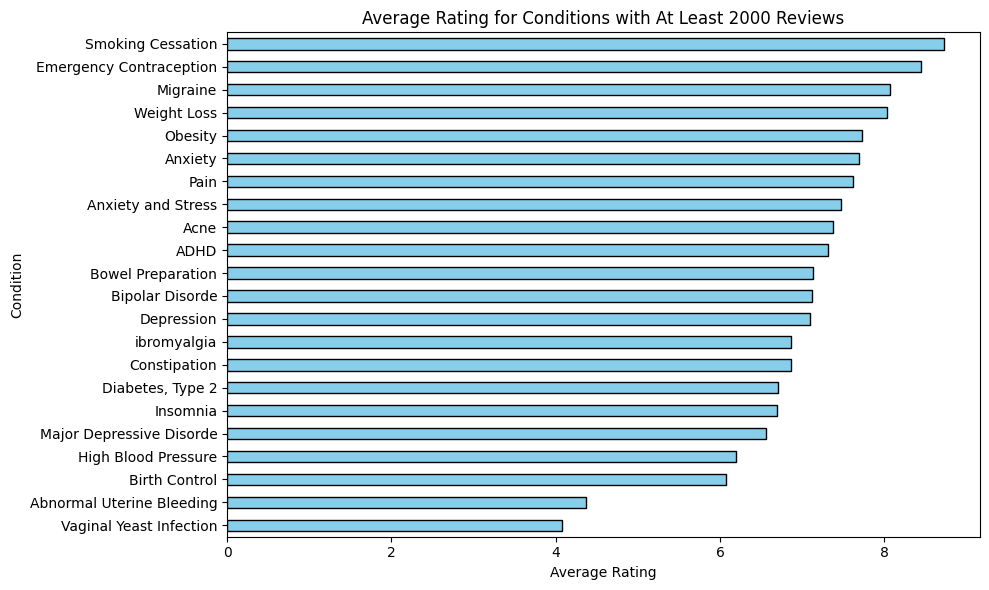

In [7]:
# Filter conditions with at least 2000 reviews
conditions_at_least_2000_reviews = condition_review_counts[condition_review_counts >= 2000].index
filtered_avg_ratings_2000 = avg_rating_per_condition.loc[conditions_at_least_2000_reviews]

plt.figure(figsize=(10, 6))
filtered_avg_ratings_2000.sort_values().plot(kind="barh", color="skyblue", edgecolor="black")
plt.title("Average Rating for Conditions with At Least 2000 Reviews")
plt.xlabel("Average Rating")
plt.ylabel("Condition")
plt.tight_layout()

# Show the plot
plt.show()


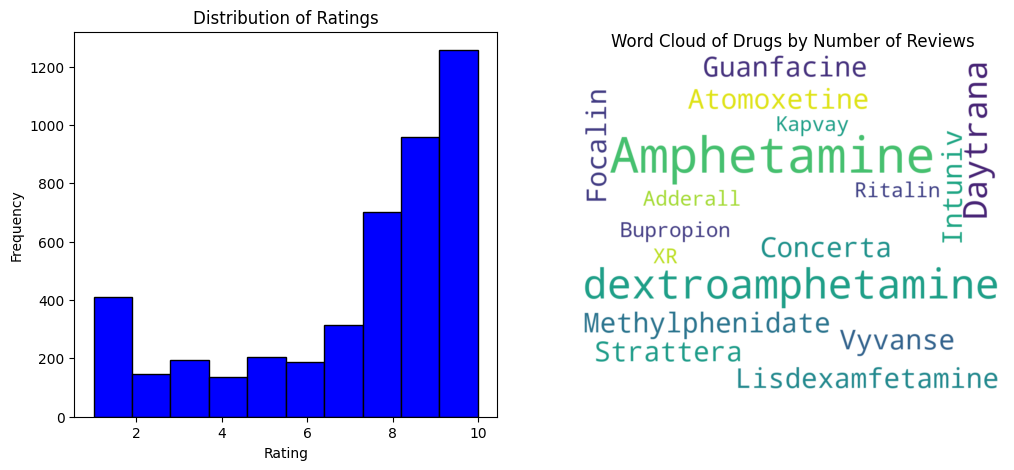

<Figure size 640x480 with 0 Axes>

In [8]:
adhd = drug_features[drug_features["condition"] == "ADHD"]

plt.figure(figsize=(12, 5))

# Histogram for "rating"
plt.subplot(1, 2, 1)
plt.hist(adhd["rating"], bins=10, color="blue", edgecolor="black")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")


# Generate a string of all drug names repeated based on their counts
drug_counts = adhd["drugName"].head(30).value_counts()
drug_string = " ".join([f"{drug} " * count for drug, count in drug_counts.items()])

# Create the word cloud
wordcloud = WordCloud(width=1000, height=800, background_color="white").generate(drug_string)

# Plot the word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Turn off the axis
plt.title("Word Cloud of Drugs by Number of Reviews")
plt.show()

# Display the plots
plt.tight_layout()
plt.show()

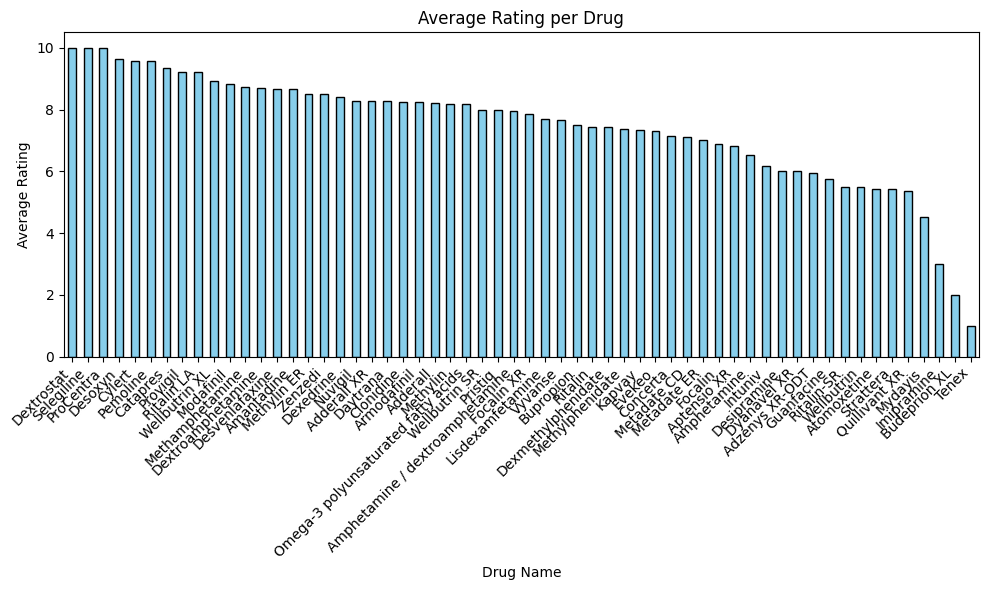

In [9]:
# Calculate the average rating for each drug
avg_rating_per_drug = adhd.groupby("drugName")["rating"].mean()

# Plotting the average rating per drug
plt.figure(figsize=(10, 6))
avg_rating_per_drug.sort_values(ascending=False).plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Rating per Drug")
plt.xlabel("Drug Name")
plt.ylabel("Average Rating")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

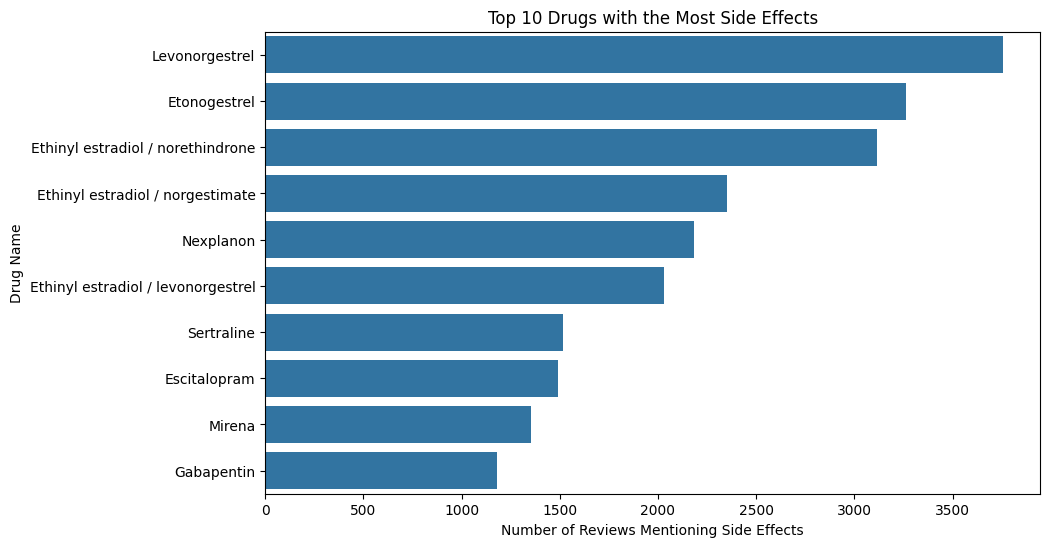

In [10]:
from utils.side_effects import check_side_effects

#create a total data from the Drugs
data_original = Drugs.data.original
# Apply the function to the review text and create the 'side_effects' column
data_original['side_effects'] = data_original['review'].apply(check_side_effects)

# Check the distribution of the new target variable
side_effect_counts = data_original['side_effects'].value_counts()
#print(f"Side Effect Target Distribution:\n{side_effect_counts}")

# Group by drug name and sum the 'side_effects' column to count how many reviews mention side effects for each drug
side_effects_by_drug = data_original.groupby('drugName')['side_effects'].sum().reset_index()

# Sort the results to find the drugs with the most side effects
side_effects_by_drug_sorted = side_effects_by_drug.sort_values(by='side_effects', ascending=False)

# Show the top 10 drugs with the most side effects
#print("Top 10 Drugs with the Most Side Effects:")
#print(side_effects_by_drug_sorted.head(10))

# Optionally, plot the top 10 drugs with the most side effects
plt.figure(figsize=(10, 6))
sns.barplot(x='side_effects', y='drugName', data=side_effects_by_drug_sorted.head(10))
plt.title('Top 10 Drugs with the Most Side Effects')
plt.xlabel('Number of Reviews Mentioning Side Effects')
plt.ylabel('Drug Name')
plt.show()

Average rating for negative sentiment (sentiment < 0): 6.08
Average rating for neutral/positive sentiment (sentiment >= 0): 7.93


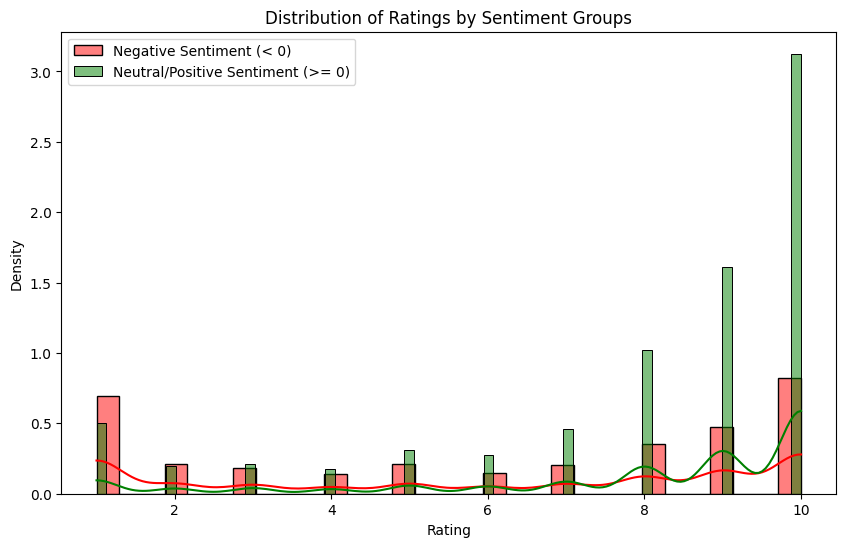

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
sid = SentimentIntensityAnalyzer()

# Split the data into 75% training and 25% testing
train_df, test_df = train_test_split(data_original, test_size=0.25, random_state=42)
# Preprocess text for sentiment analysis (get sentiment score from review text)
data_original['sentiment'] = data_original['review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Separate the data into two groups: negative (sentiment < 0) and neutral/positive (sentiment >= 0)
negative = data_original[data_original['sentiment'] < 0]
neutral_positive = data_original[data_original['sentiment'] >= 0]

avg_rating_negative = negative['rating'].mean()
avg_rating_neutral_positive = neutral_positive['rating'].mean()

# Print the results
print(f"Average rating for negative sentiment (sentiment < 0): {avg_rating_negative:.2f}")
print(f"Average rating for neutral/positive sentiment (sentiment >= 0): {avg_rating_neutral_positive:.2f}")

# plot the distribution of ratings for each sentiment group
plt.figure(figsize=(10, 6))
sns.histplot(negative['rating'], color='red', label='Negative Sentiment (< 0)', kde=True, stat='density')
sns.histplot(neutral_positive['rating'], color='green', label='Neutral/Positive Sentiment (>= 0)', kde=True, stat='density')
plt.title('Distribution of Ratings by Sentiment Groups')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.show()


Train Accuracy: 0.7311325165996446
Test Accuracy: 0.71430975801324
              precision    recall  f1-score   support

           0       0.56      0.20      0.30     16000
           1       0.73      0.93      0.82     37474

    accuracy                           0.71     53474
   macro avg       0.65      0.57      0.56     53474
weighted avg       0.68      0.71      0.66     53474

                               Drug Name                 Condition  \
14311        Acetaminophen / hydrocodone                      Pain   
72301                         Vilazodone  Major Depressive Disorde   
23041                        Eluxadoline  Irritable Bowel Syndrome   
197721  Ethinyl estradiol / etonogestrel             Birth Control   
133612                   Methylphenidate                      ADHD   

        Actual Effectiveness  Predicted Effectiveness  
14311                      1                        1  
72301                      0                        0  
23041            

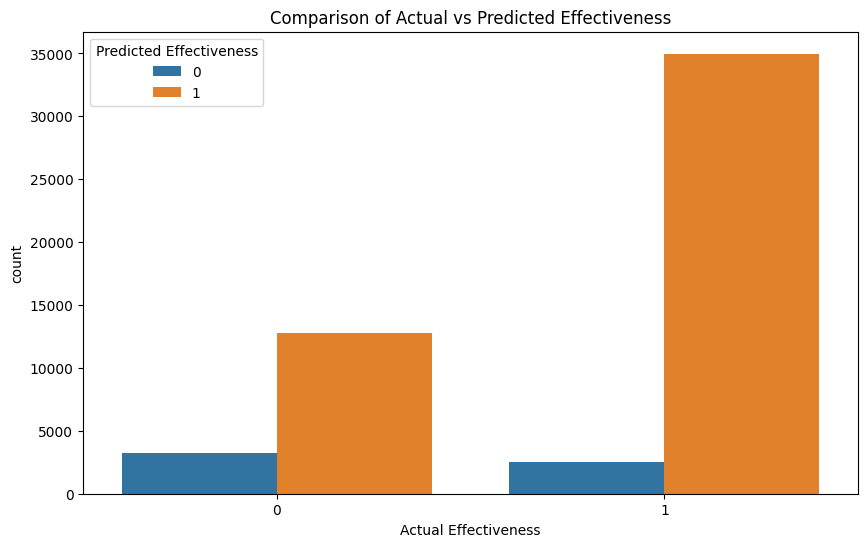

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define effectiveness for training data, here we assumed the ratings > 5 means effective, which can be adjusted withe the previous section of sentiment + rating 

train_df['effective'] = train_df.apply(
    lambda row: 1 if row['rating'] > 5 else 0, axis=1
)

# Define effectiveness for test data in the same way
test_df['effective'] = test_df.apply(
    lambda row: 1 if row['rating'] > 5 else 0, axis=1
)


# Handle missing data
train_df.dropna(subset=['drugName', 'condition', 'rating'], inplace=True)
test_df.dropna(subset=['drugName', 'condition', 'rating'], inplace=True)

# Encode categorical variables (Drug name, Condition)
le_drug = LabelEncoder()
le_condition = LabelEncoder()

train_df['drug_encoded'] = le_drug.fit_transform(train_df['drugName'])
train_df['condition_encoded'] = le_condition.fit_transform(train_df['condition'])

# Define a safe transformation function to handle unseen labels
def safe_transform(encoder, data, default_value=-1):
    return np.array([default_value if label not in encoder.classes_ else encoder.transform([label])[0] for label in data])

# Apply safe transformation on the test data to handle unseen drugs and conditions
test_df['drug_encoded'] = safe_transform(le_drug, test_df['drugName'])
test_df['condition_encoded'] = safe_transform(le_condition, test_df['condition'])

# Define the input features (drug name and condition) and the target variable (effectiveness)
X_train = train_df[['drug_encoded', 'condition_encoded']]
y_train = train_df['effective']

X_test = test_df[['drug_encoded', 'condition_encoded']]
y_test = test_df['effective']

# Train a Random Forest classifier using drug name and condition as input features
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set using drug name and condition
y_pred = clf.predict(X_test)

# Evaluate the model
print(f"Train Accuracy: {accuracy_score(y_train, clf.predict(X_train))}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Create a comparison table of actual vs predicted values
comparison_df = pd.DataFrame({
    'Drug Name': test_df['drugName'],
    'Condition': test_df['condition'],
    'Actual Effectiveness': y_test,
    'Predicted Effectiveness': y_pred
})

print(comparison_df.head())

# Plot the predicted effectiveness for a few drug-condition pairs
plt.figure(figsize=(10, 6))
sns.countplot(x='Actual Effectiveness', hue='Predicted Effectiveness', data=comparison_df)
plt.title('Comparison of Actual vs Predicted Effectiveness')
plt.show()

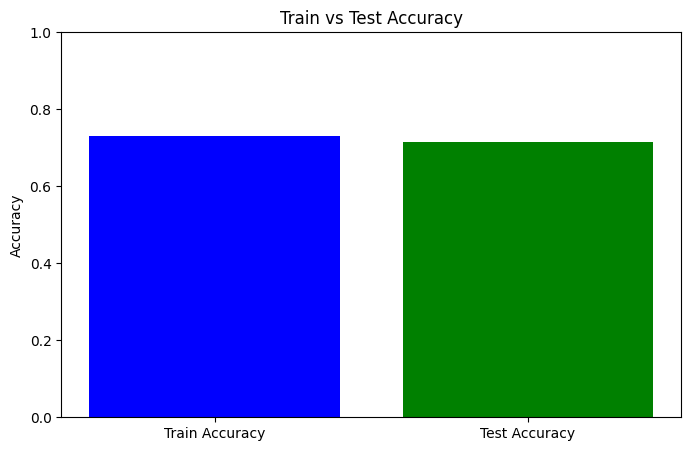

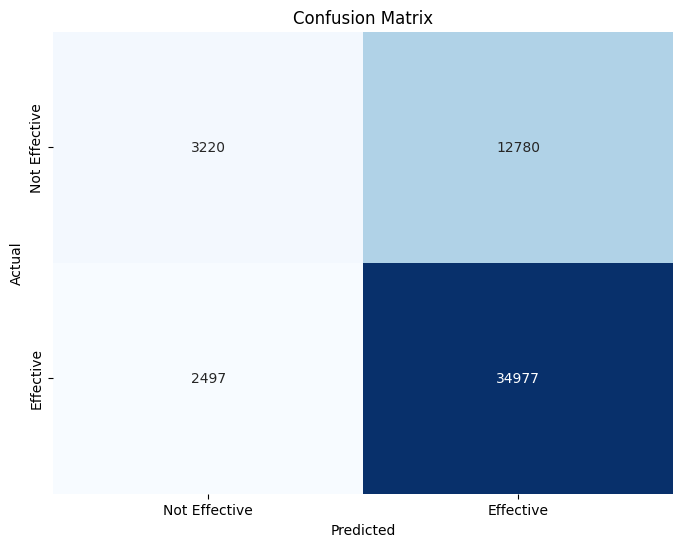

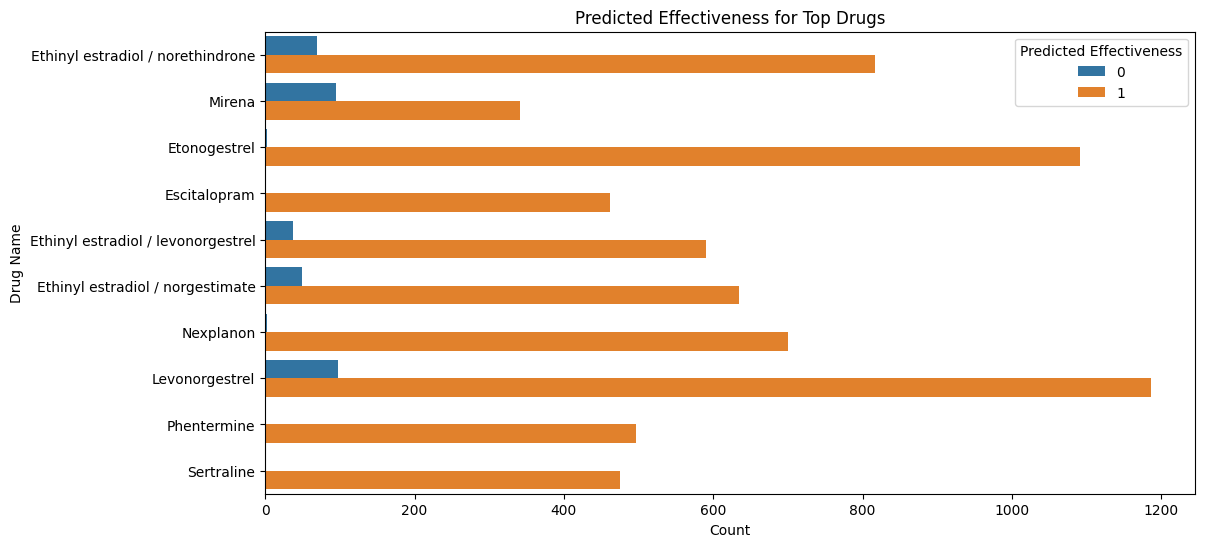

In [13]:
#Some visualizations, we can pick and chose what we want to keep 

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Train and Test Accuracy as a bar plot
plt.figure(figsize=(8, 5))
accuracy_values = [accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, y_pred)]
plt.bar(['Train Accuracy', 'Test Accuracy'], accuracy_values, color=['blue', 'green'])
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Effective', 'Effective'], yticklabels=['Not Effective', 'Effective'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Bar plot of Predicted Effectiveness for different drugs
plt.figure(figsize=(12, 6))
top_drugs = comparison_df['Drug Name'].value_counts().index[:10]
sns.countplot(y='Drug Name', hue='Predicted Effectiveness', data=comparison_df[comparison_df['Drug Name'].isin(top_drugs)])
plt.title('Predicted Effectiveness for Top Drugs')
plt.xlabel('Count')
plt.ylabel('Drug Name')
plt.legend(title='Predicted Effectiveness', loc='upper right')
plt.show()




Correlation Matrix (without Sentiment):
                    id    rating  usefulCount  side_effects
id            1.000000  0.016336     0.017567     -0.002099
rating        0.016336  1.000000     0.234860     -0.095636
usefulCount   0.017567  0.234860     1.000000     -0.009935
side_effects -0.002099 -0.095636    -0.009935      1.000000


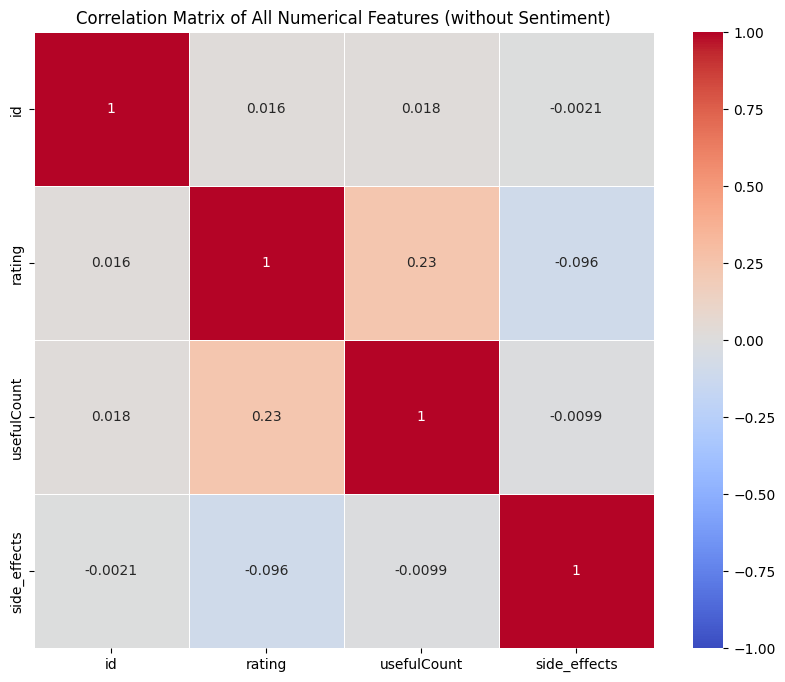

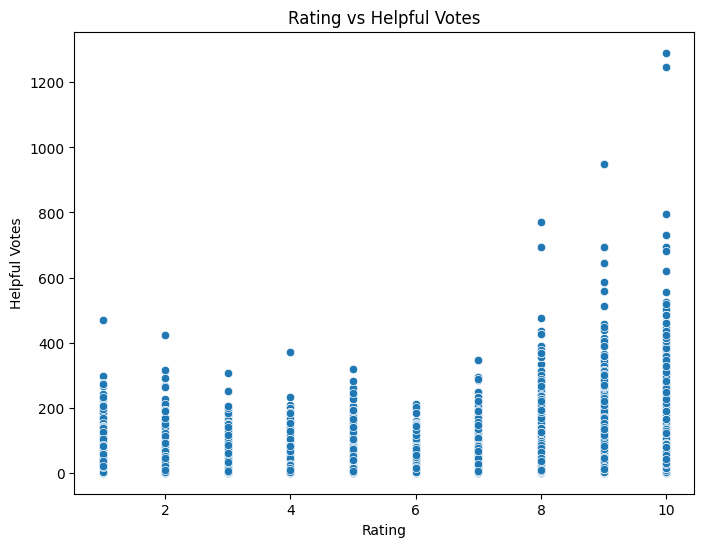

In [14]:
#Some additional descriptive analysis that could be useful 

# Select all numerical columns except 'sentiment'
numerical_columns = data_original.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop('sentiment', errors='ignore')  # Exclude sentiment if it's present

# Calculate the correlation matrix for the selected numerical features
correlation_matrix = data_original[numerical_columns].corr()

# Display the correlation matrix
print("Correlation Matrix (without Sentiment):")
print(correlation_matrix)

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, linewidths=0.5)
plt.title('Correlation Matrix of All Numerical Features (without Sentiment)')
plt.show()

# Scatter plot for rating vs usefulCount (helpful votes)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='rating', y='usefulCount', data=data_original)
plt.title('Rating vs Helpful Votes')
plt.xlabel('Rating')
plt.ylabel('Helpful Votes')
plt.show()


Top 10 Most Reviewed Drugs:
drugName
Levonorgestrel                        4930
Etonogestrel                          4421
Ethinyl estradiol / norethindrone     3753
Nexplanon                             2892
Ethinyl estradiol / norgestimate      2790
Ethinyl estradiol / levonorgestrel    2503
Phentermine                           2085
Sertraline                            1868
Escitalopram                          1747
Mirena                                1673
Name: count, dtype: int64


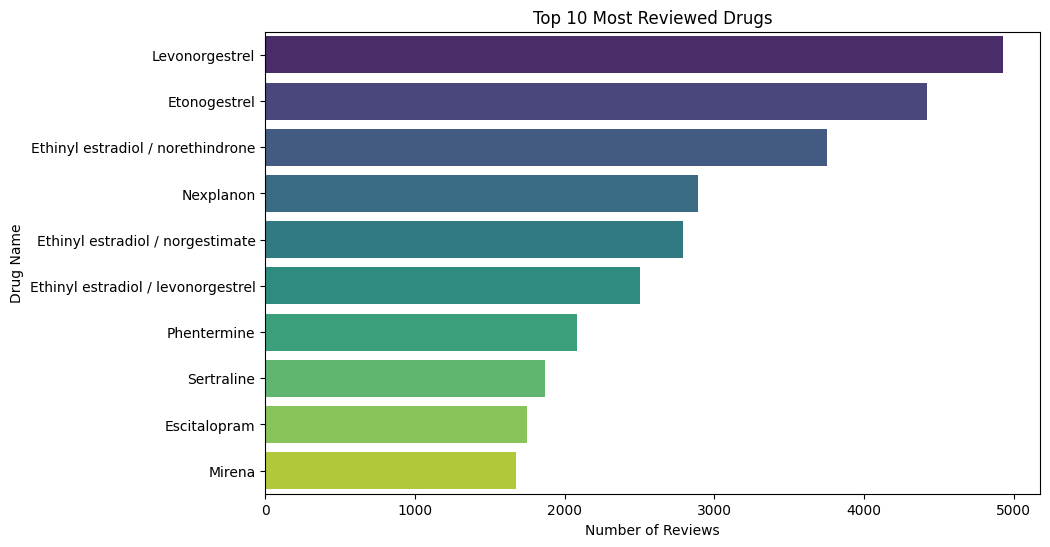

Top 10 Most Reviewed Conditions:
condition
Birth Control      38436
Depression         12164
Pain                8245
Anxiety             7812
Acne                7435
Bipolar Disorde     5604
Insomnia            4904
Weight Loss         4857
Obesity             4757
ADHD                4509
Name: count, dtype: int64


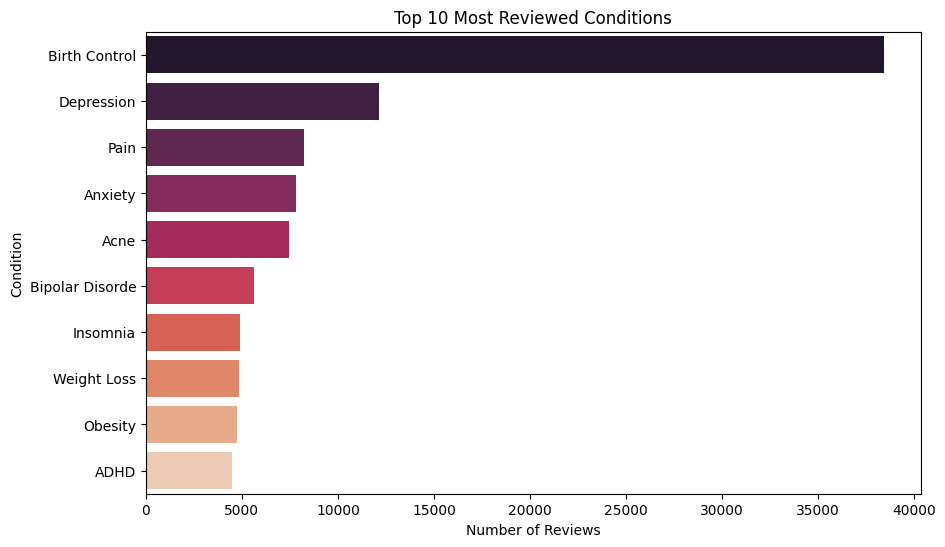

Top 10 Drug-Condition Pairs by Number of Reviews:
                                drugName                condition  num_reviews
3307                        Etonogestrel            Birth Control         4394
3283   Ethinyl estradiol / norethindrone            Birth Control         3081
4790                      Levonorgestrel            Birth Control         2884
6012                           Nexplanon            Birth Control         2883
3274  Ethinyl estradiol / levonorgestrel            Birth Control         2107
3292    Ethinyl estradiol / norgestimate            Birth Control         2097
4791                      Levonorgestrel  Emergency Contraception         1651
6693                         Phentermine              Weight Loss         1650
4233                            Implanon            Birth Control         1496
5527                          Miconazole  Vaginal Yeast Infection         1338


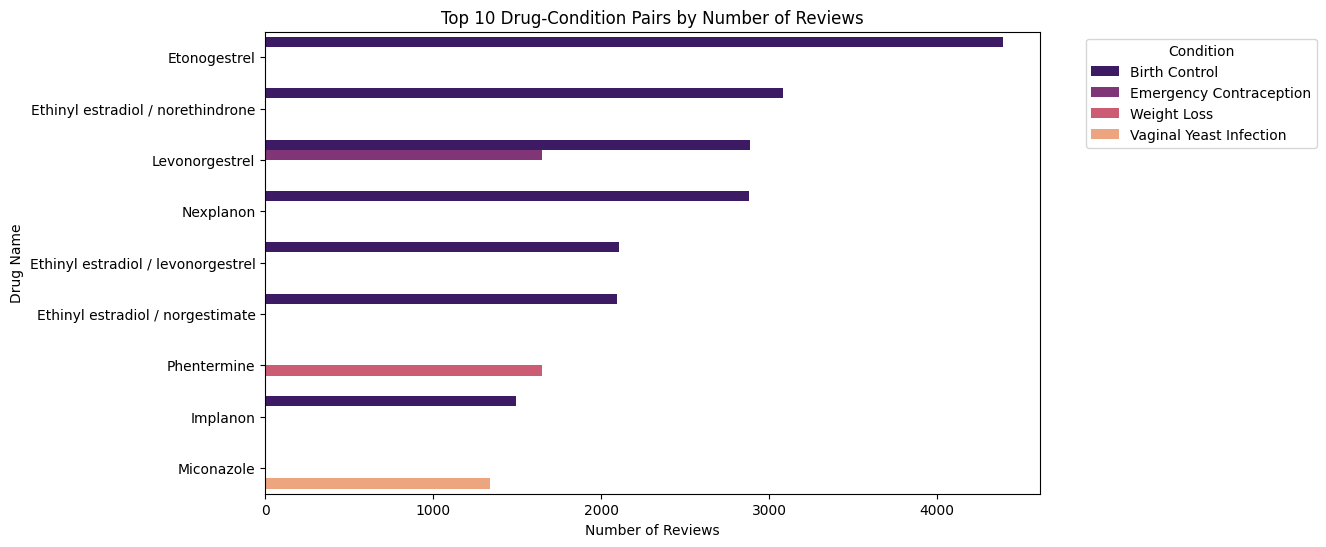

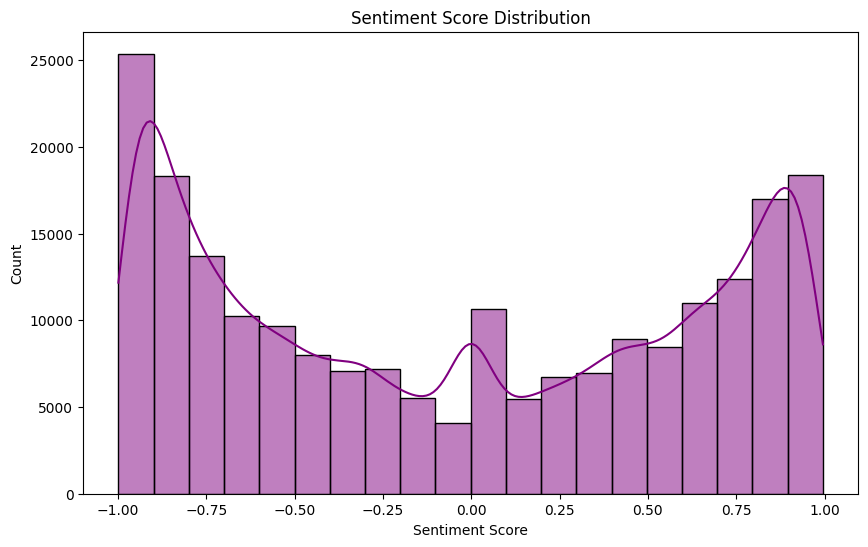

Sentiment Distribution:
Negative: 109249 reviews
Neutral: 6767 reviews
Positive: 99047 reviews


In [18]:
# Top 10 most common drugs
top_drugs = data_original['drugName'].value_counts().head(10)
print("Top 10 Most Reviewed Drugs:")
print(top_drugs)

# Visualize the top 10 most common drugs
plt.figure(figsize=(10, 6))
sns.barplot(x=top_drugs.values, y=top_drugs.index, hue=top_drugs.index, legend=False, palette="viridis")
plt.title('Top 10 Most Reviewed Drugs')
plt.xlabel('Number of Reviews')
plt.ylabel('Drug Name')
plt.show()

# Top 10 most common conditions
top_conditions = data_original['condition'].value_counts().head(10)
print("Top 10 Most Reviewed Conditions:")
print(top_conditions)

# Visualize the top 10 conditions
plt.figure(figsize=(10, 6))
sns.barplot(x=top_conditions.values, y=top_conditions.index, hue=top_conditions.index, legend=False, palette="rocket")
plt.title('Top 10 Most Reviewed Conditions')
plt.xlabel('Number of Reviews')
plt.ylabel('Condition')
plt.show()

# Number of reviews per drug and condition
reviews_per_drug_condition = data_original.groupby(['drugName', 'condition']).size().reset_index(name='num_reviews')
top_drug_condition = reviews_per_drug_condition.sort_values(by='num_reviews', ascending=False).head(10)

print("Top 10 Drug-Condition Pairs by Number of Reviews:")
print(top_drug_condition)

# Visualize the top drug-condition pairs
plt.figure(figsize=(10, 6))
sns.barplot(x='num_reviews', y='drugName', hue='condition', data=top_drug_condition, palette="magma")
plt.title('Top 10 Drug-Condition Pairs by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Drug Name')
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(data_original['sentiment'], bins=20, kde=True, color='purple')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

# Show how many reviews have positive, negative, or neutral sentiment
print("Sentiment Distribution:")
sentiment_labels = ['Negative', 'Neutral', 'Positive']
sentiment_distribution = [
    (data_original['sentiment'] < 0).sum(),
    (data_original['sentiment'] == 0).sum(),
    (data_original['sentiment'] > 0).sum()
]
for label, count in zip(sentiment_labels, sentiment_distribution):
    print(f"{label}: {count} reviews")



                               drugName  year     rating
0             A + D Cracked Skin Relief  2009  10.000000
1                            A / B Otic  2009  10.000000
2  Abacavir / dolutegravir / lamivudine  2014  10.000000
3  Abacavir / dolutegravir / lamivudine  2015   8.904762
4  Abacavir / dolutegravir / lamivudine  2016   8.218750


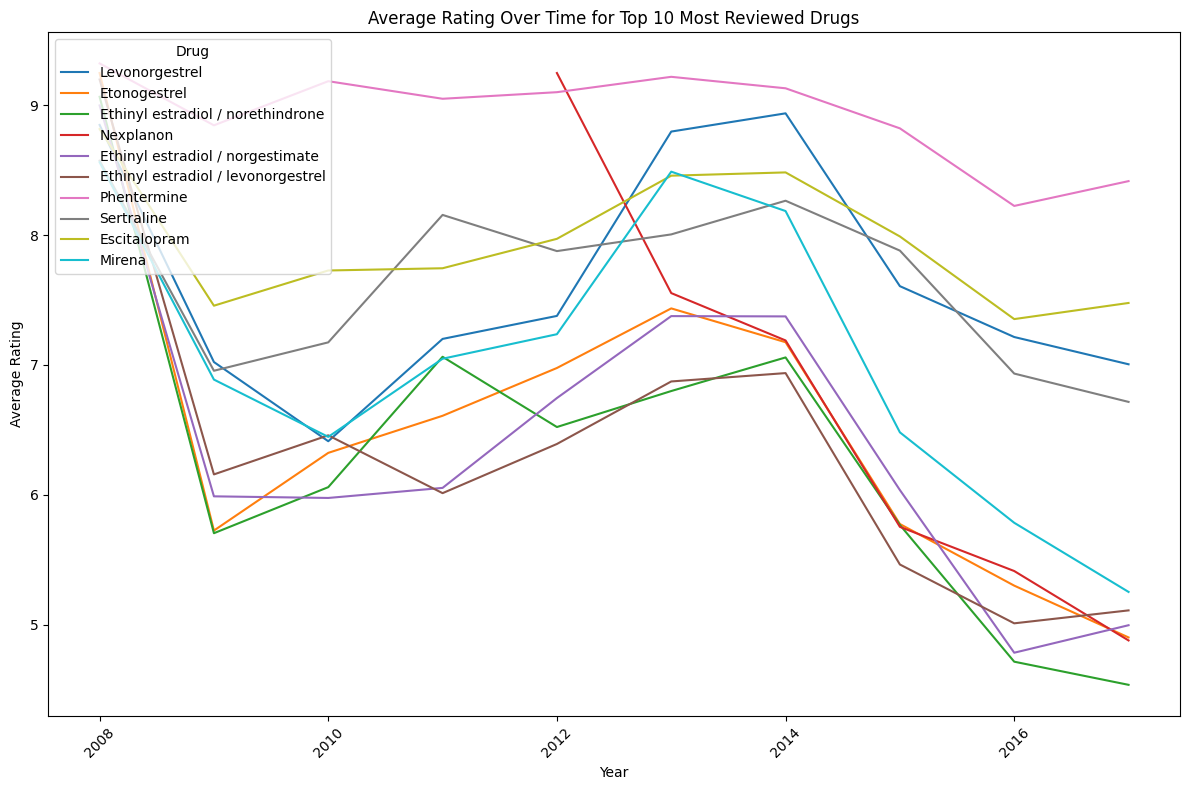

In [19]:
#Including the effect of time aka including the date information

# Convert 'date' column to datetime format
data_original['date'] = pd.to_datetime(data_original['date'], format="%d/%m/%Y", errors='coerce')

# Extract year from the date
data_original['year'] = data_original['date'].dt.year

# Group by drug and year, then calculate the average rating
ratings_by_year = data_original.groupby(['drugName', 'year'])['rating'].mean().reset_index()

# Check the first few rows
print(ratings_by_year.head())


# Identify the top 10 most used drugs (based on number of reviews)
top_10_drugs = data_original['drugName'].value_counts().head(10).index

# Group by drug and year, then calculate the average rating
ratings_by_year_top_drugs = data_original[data_original['drugName'].isin(top_10_drugs)].groupby(['drugName', 'year'])['rating'].mean().reset_index()

# Plot average ratings over time for the top 10 drugs
plt.figure(figsize=(12, 8))

# Plotting for each drug
for drug in top_10_drugs:
    sns.lineplot(x='year', y='rating', data=ratings_by_year_top_drugs[ratings_by_year_top_drugs['drugName'] == drug], label=drug)

plt.title('Average Rating Over Time for Top 10 Most Reviewed Drugs')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.legend(title='Drug', loc='upper left')
plt.tight_layout()
plt.show()




In [17]:
import ipywidgets as widgets
from IPython.display import display

# Assuming we have the 'data_original' DataFrame loaded with 'rating', 'drugName', 'condition', etc.

# Step 1: Define effectiveness using percentiles of the ratings to add more variance
# Compute percentiles and scale effectiveness
data_original['percentile_effectiveness'] = data_original.groupby('condition')['rating'].rank(pct=True) * 100  # Rank ratings per condition and scale to 0-100%

# Step 2: Group by condition and drug, then calculate the mean percentile effectiveness as the confidence
effectiveness_by_condition = data_original.groupby(['condition', 'drugName']).agg(
    average_rating=('rating', 'mean'),
    confidence=('percentile_effectiveness', 'mean')  # Now using percentile effectiveness as confidence
).reset_index()

# Step 3: Function to get the best drug for a given condition
def get_best_drug(condition):
    condition_data = effectiveness_by_condition[effectiveness_by_condition['condition'] == condition]
    
    if condition_data.empty:
        return "No data available", 0
    
    best_drug = condition_data.sort_values(by='confidence', ascending=False).iloc[0]
    
    return best_drug['drugName'], best_drug['confidence']  # Return the confidence based on percentile effectiveness

# Step 4: Create a dropdown widget for selecting a condition
condition_dropdown = widgets.Dropdown(
    options=data_original['condition'].unique(),
    description='Condition:',
    disabled=False
)

# Step 5: Create a label widget to display the best drug and confidence
result_label = widgets.Label(value="Select a condition to see the best drug")

# Step 6: Function to update the result when a condition is selected
def on_condition_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_condition = change['new']
        best_drug, confidence = get_best_drug(selected_condition)
        result_label.value = f"Best Drug: {best_drug}\nConfidence: {confidence:.2f}%"

# Attach the function to the dropdown widget
condition_dropdown.observe(on_condition_change)

# Display the dropdown and result label in the notebook
display(condition_dropdown)
display(result_label)


Dropdown(description='Condition:', options=('Left Ventricular Dysfunction', 'ADHD', 'Birth Control', 'Opiate D…

Label(value='Select a condition to see the best drug')